In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/content/drive/MyDrive/flickr'
WORKING_DIR = '/content'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
!ls /content/flickr8k
!ls /content/flickr8k/images
!ls /content/flickr8k/images/Images


ls: cannot access '/content/flickr8k': No such file or directory
ls: cannot access '/content/flickr8k/images': No such file or directory
ls: cannot access '/content/flickr8k/images/Images': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8101 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

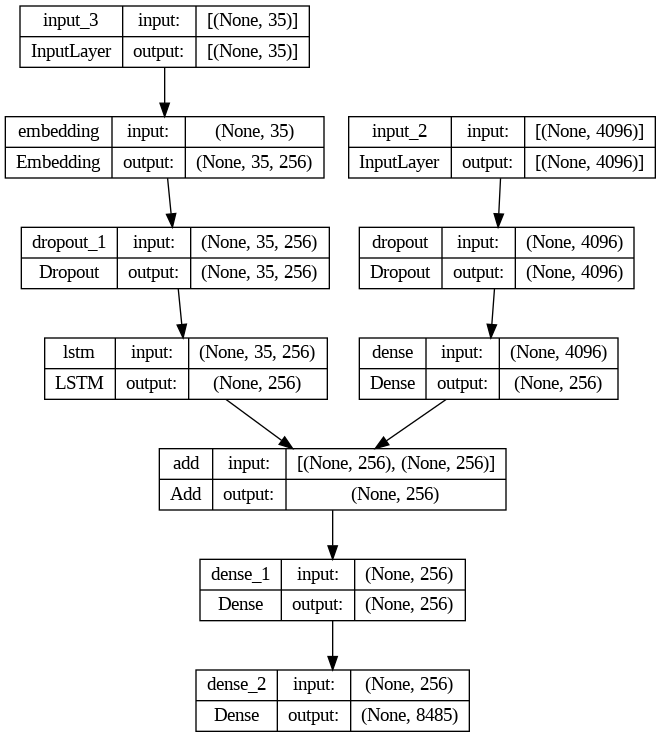

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Specify the relative path to the source image file
relative_source_path = 'drive/MyDrive/archive/image.jpg'

# Construct the full path
full_source_path = os.path.join(current_directory, relative_source_path)

# Print and use the full source path
print(f"Full Source Path: {full_source_path}")

Full Source Path: /content/drive/MyDrive/archive/image.jpg


In [ ]:
import shutil
import os

# Specify paths
source_path = '/content/drive/MyDrive/archive/Images'  # Replace with the actual path of your image file
BASE_DIR= '/content/drive/MyDrive/archive/dataset/'     # Replace with the actual path of your dataset directory
image_filename = '1488937076_5baa73fc2a.jpg'  # Replace with the desired filename

# Copy the image file to the dataset directory
shutil.copy(source_path, os.path.join(BASE_DIR, '1488937076_5baa73fc2a.jpg'))


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/archive/Images'

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)




  4/227 [..............................] - ETA: 20:08 - loss: 4.2074

KeyboardInterrupt: 

In [ ]:
# Print features for a few keys
keys_to_check = ['1488937076_5baa73fc2a', 'another_key', 'yet_another_key']
for key in keys_to_check:
    if key in features:
        print(f"Features for key '{key}': {features[key]}")
    else:
        print(f"Key '{key}' not found in the features dictionary.")


Key '1488937076_5baa73fc2a' not found in the features dictionary.
Key 'another_key' not found in the features dictionary.
Key 'yet_another_key' not found in the features dictionary.


In [ ]:
import os

image_filename = '1488937076_5baa73fc2a.jpg'  # Adjust the extension if necessary
image_path = os.path.join(BASE_DIR, image_filename)  # Adjust 'dataset_directory' to your dataset directory

if os.path.exists(image_path):
    print(f"The image file {image_filename} exists in the dataset.")
else:
    print(f"The image file {image_filename} does not exist in the dataset.")

The image file 1488937076_5baa73fc2a.jpg does not exist in the dataset.


In [ ]:
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm  # Correct import
import nltk
nltk.download('punkt')

actual, predicted = list(), list()

for key in tqdm(test):
    # Check if the key is in the features dictionary
    if key not in features:
        print(f"Key '{key}' not found in the features dictionary. Skipping this data point.")
        continue

    # Get actual captions
    captions = mapping[key]
    actual_captions = [word_tokenize(caption) for caption in captions]

    # Predict the caption for the image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred_tokens = word_tokenize(y_pred)

    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred_tokens)

# Calculate BLEU score
if not actual or not predicted:
    print("Reference or candidate lists are empty. Unable to calculate BLEU.")
else:
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    print("BLEU-1: %f" % bleu_1)
    print("BLEU-2: %f" % bleu_2)




In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq dog is running on the the endseq


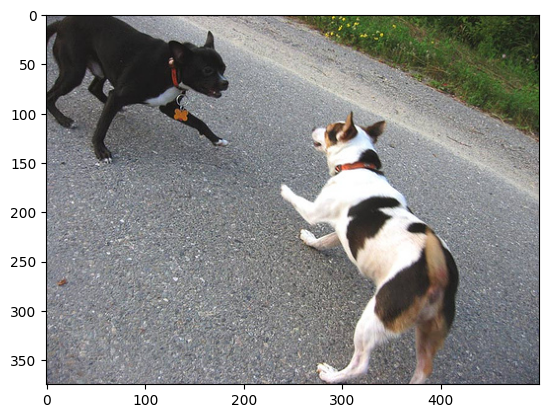

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little boy in the blue shirt and shirt and shirt and shirt and shirt and shirt and white and white and white and white and white and white and people in the green and white


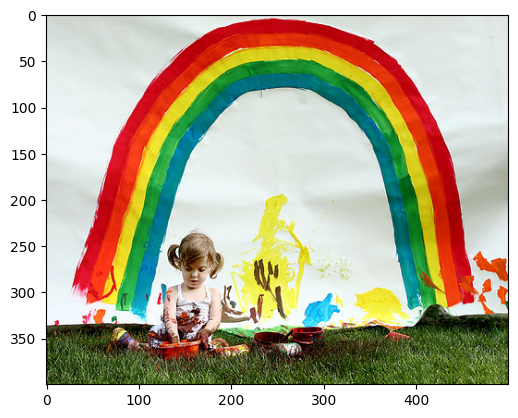

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq man in snow in snow endseq


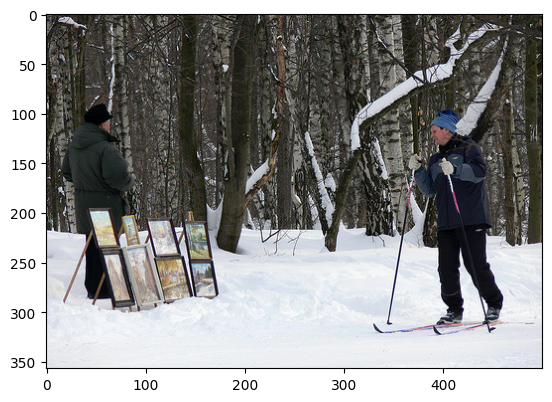

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man eats near tent in the snow endseq
startseq man sitting near tent in the snow and ice endseq
startseq mountaineer sits in the snow in front of yellow tent under clear blue sky endseq
startseq person wearing hooded jacket sitting on snow in front of yellow tent endseq
startseq young man in hooded jacket sitting on snow in mountain area endseq
--------------------Predicted--------------------
startseq man is is is is is in the snow endseq


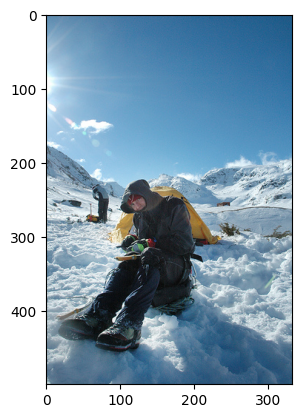

In [ ]:
generate_caption("116409198_0fe0c94f3b.jpg")

---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
--------------------Predicted--------------------
startseq white dog running in the snow endseq


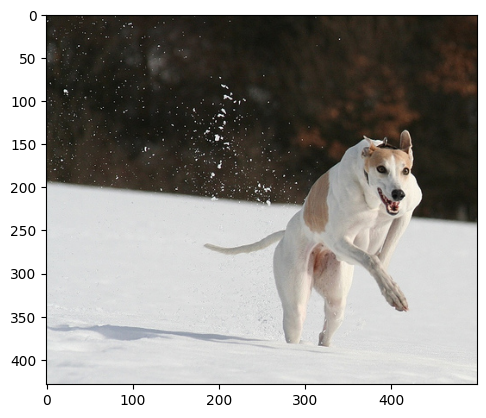

In [ ]:
generate_caption("101654506_8eb26cfb60.jpg")

---------------------Actual---------------------
startseq man riding his bike on hill endseq
startseq man with helmet and backpack standing on dirt bike in hilly grassy area endseq
startseq person rides motorbike through grassy field endseq
startseq man on motorcycle riding in dry field wearing helmet and backpack endseq
startseq the biker is riding through grassy plain endseq
--------------------Predicted--------------------
startseq man is riding bike on bike endseq


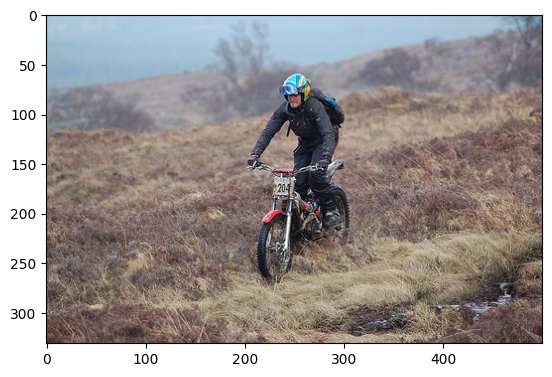

In [ ]:
generate_caption("143552697_af27e9acf5.jpg")

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [ ]:
image_path = '/content/drive/MyDrive/archive/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq girl in in in endseq'

In [ ]:
key = '1488937076_5baa73fc2a'
if key in features:
    # Access the key in your code
    X1.append(features[key][0])
else:
    print(f"Key '{key}' not found in the features dictionary.")

Key '1488937076_5baa73fc2a' not found in the features dictionary.


In [ ]:
key = '1488937076_5baa73fc2a'
if key in features:
    X1.append(features[key][0])
else:
    # Handle missing key, for example:
    print(f"Key '{key}' not found in the features dictionary. Skipping this data point.")


Key '1488937076_5baa73fc2a' not found in the features dictionary. Skipping this data point.


In [ ]:
import os

path = '/content/drive/MyDrive/archive/Images'
if os.path.exists(path):
    print("Path exists.")
    print("Contents of the directory:")
    print(os.listdir(path))
else:
    print("Path does not exist.")

Path exists.
Contents of the directory:
['1001773457_577c3a7d70.jpg', '1000268201_693b08cb0e.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1019604187_d087bf9a5f.jpg', '1009434119_febe49276a.jpg', '1019077836_6fc9b15408.jpg', '1012212859_01547e3f17.jpg', '1007320043_627395c3d8.jpg', '1015118661_980735411b.jpg', '102351840_323e3de834.jpg', '1016887272_03199f49c4.jpg', '1022975728_75515238d8.jpg', '101654506_8eb26cfb60.jpg', '1022454428_b6b660a67b.jpg', '1015584366_dfcec3c85a.jpg', '101669240_b2d3e7f17b.jpg', '1007129816_e794419615.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1032460886_4a598ed535.jpg', '103195344_5d2dc613a3.jpg', '102455176_5f8ead62d5.jpg', '103205630_682ca7285b.jpg', '1045521051_108ebc19be.jpg', '1048710776_bb5b0a5c7c.jpg', '103106960_e8a41d64f8.jpg', '1024138940_f1fefbdce1.jpg', '1042590306_95dea0916c.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '103212227

In [ ]:
data_path = '/content/drive/MyDrive/archive/Images'

In [ ]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content


In [ ]:
import os

content_dir = '/content'
print("Contents of the /content directory:")
print(os.listdir(content_dir))


Contents of the /content directory:
['.config', 'drive', 'sample_data']


In [ ]:
import os

content_dir = '/content'
print("Contents of the /content directory:")
print(os.listdir(content_dir))

Contents of the /content directory:
['.config', 'drive', 'sample_data']


In [ ]:
data_path = '/content/drive/MyDrive/archive/Images'

In [ ]:
from google.colab import files

# Upload the zip file containing the dataset
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable